# Weekly戦略開発のための基本調査
Weekly戦略とは、「仕掛けは月曜始値（実際は日曜夕方のオープン直後）のみに限定して、手仕舞いはその週内（最長で金曜日の大引けまで）」という縛りを設けた戦略。

## 背景
- 最初の戦略だから、まずはできる限り問題を単純化して落とし穴にはまりにくいところで戦う方が安全だろう。
- 先物は限月取引という性質があるため、時間枠はあまり長くしたくないが利を伸ばすためにはイントラデイトレードに限定せず数日ポジションを保有することを考慮に入れた戦略のほうがよさそうだ。
- 金曜日の大引けから日曜夕方の寄り付きまでは48時間程度空いているため、その間の価格ギャップはその週初めの値動き予測に使えそうだ。
- 上記の48時間の間になにか世界で大きなイベントが発生したときに価格が大きく動いても（上昇でも下落でも）損切りが機能しないためこの間ポジションを保有し続けることはリスクが大きい。

## 基本調査内容
- 一週間値動き（金終値 - 月始値）の分布
- 年毎、月毎などで損益の変動があるか

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
import locale

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# 一週間値動きの分布
これって要するに週足データ（終値 - 始値）を分析すればよいということだ

In [2]:
# 週足データ
base_dir = 'data/e-mini-sp500-200530'
dfw_raw = pd.read_csv(f'{base_dir}/e-mini-sp500-weekly.csv')
dfw_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1186 non-null   object 
 1   Time    1186 non-null   object 
 2   Open    1186 non-null   float64
 3   High    1186 non-null   float64
 4   Low     1186 non-null   float64
 5   Close   1186 non-null   float64
 6   Vol     1186 non-null   int64  
 7   OI      1186 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 74.2+ KB


In [3]:
dfw_raw.head(3)

,Date,Time,Open,High,Low,Close,Vol,OI
0,09/12/1997,17:00,1071.25,1089.0,1062.75,1071.25,21584,4059
1,09/19/1997,17:00,1086.00,1123.0,1081.50,1113.50,52617,5836
2,09/26/1997,17:00,1112.75,1124.5,1098.00,1106.00,62967,5666


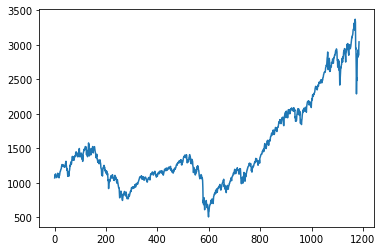

In [10]:
dfw_raw['Close'].plot()

## 前処理
- 年単位の分析もするため、半端になっている最初の年（1997）と最後の年（2020）は除外する
- 始めの数年間は直近と比べると出来高が非常に小さく流動性が低いが、今は週単位での値動きに注目しているため問題ないとみなして、それらのデータを除外しない

だから、1998年初めから2019年終わりまでのデータを使用する。

In [19]:
# DateをDatetime型にする
dfw = dfw_raw.copy()
dfw['Date'] = dfw['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').date())

# 最初の年（1997）と最後の年（2020）は1年分のデータがないから除外する
# 始まりの年と終わりの年（終わりは含まない）
s_year = 1998
e_year = 2020

dfw = dfw[(dfw['Date'] >= dt.date(s_year,1,1)) & (dfw['Date'] < dt.date(e_year,1,1))]
dfw = dfw.reset_index(drop=True)
dfw.info()
print('\n始めのデータ\n', dfw[:1])
print('\n終わりのデータ\n', dfw[-1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1148 non-null   object 
 1   Time    1148 non-null   object 
 2   Open    1148 non-null   float64
 3   High    1148 non-null   float64
 4   Low     1148 non-null   float64
 5   Close   1148 non-null   float64
 6   Vol     1148 non-null   int64  
 7   OI      1148 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 71.9+ KB

始めのデータ
          Date   Time     Open    High     Low   Close    Vol    OI
0  1998-01-02  17:00  1087.75  1127.0  1083.5  1127.0  22778  5968

終わりのデータ
             Date   Time     Open     High      Low    Close      Vol       OI
1147  2019-12-27  17:00  3215.75  3242.75  3211.25  3226.25  2932644  2697727


## 一週間値動き

- （終値 - 始値）は平均が2、標準偏差が34の正規分布になっているようだ
- （高値 - 安値）は最頻値が30～40付近のガンマ分布になっているようだ
- （高値 - 始値）は最頻値が10～15付近のガンマ分布になっているようだ
- （安値 - 始値）は最頻値が-5～0付近のガンマ分布になっているようだ

In [20]:
# 終値 - 始値
dfw['CODiff'] = dfw['Close'] - dfw['Open']

# 高値 - 安値
dfw['HLDiff'] = dfw['High'] - dfw['Low']

# 高値 - 始値
dfw['HODiff'] = dfw['High'] - dfw['Open']

# 安値 - 始値
dfw['LODiff'] = dfw['Low'] - dfw['Open']

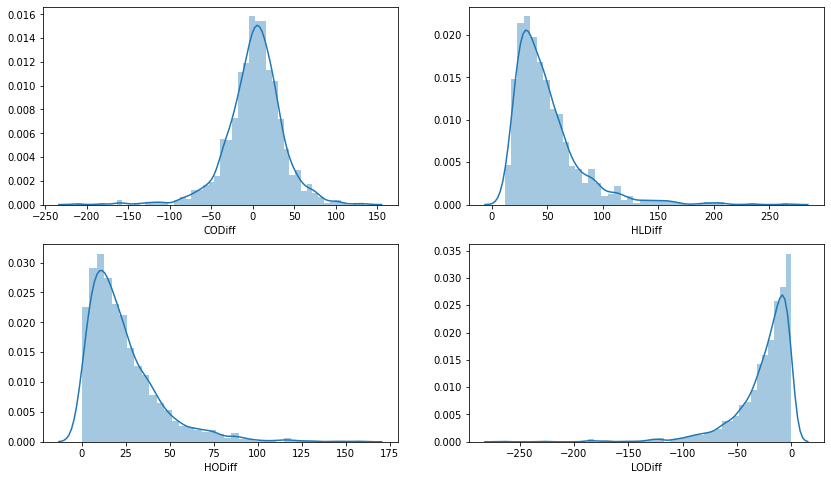

In [21]:
# 値動きの分布を可視化
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
sns.distplot(dfw['CODiff'], ax=ax[0,0])
sns.distplot(dfw['HLDiff'], ax=ax[0,1])
sns.distplot(dfw['HODiff'], ax=ax[1,0])
sns.distplot(dfw['LODiff'], ax=ax[1,1])

## 年毎の傾向を調べる

- 年毎に各値動きの平均をプロットすると、偏差のボラティリティが大きいことがわかる
- 特に2008年は金融危機の影響で乱高下していたことがわかる
- どの年でも利益を上げるには、買いも売りもトレードする必要があるだろう
- 月毎の傾向はもっとボラティリティが大きいはずだから、これ以上やる必要はないと思う

In [27]:
# 年の列を追加する
dfw['year'] = dfw['Date'].apply(lambda x: x.year)

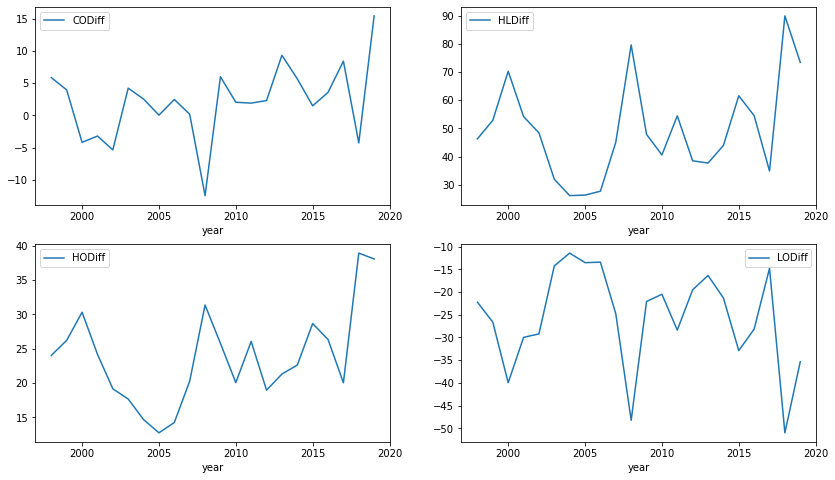

In [36]:
# 年毎の平均データ
dfw_by_year = dfw.groupby('year').mean()

fig, ax = plt.subplots(2, 2, figsize=(14, 8))
dfw_by_year.loc[:,['CODiff']].plot(ax=ax[0,0])
dfw_by_year.loc[:,['HLDiff']].plot(ax=ax[0,1])
dfw_by_year.loc[:,['HODiff']].plot(ax=ax[1,0])
dfw_by_year.loc[:,['LODiff']].plot(ax=ax[1,1])